# Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

In [2]:
train =  pd.read_parquet('../../../data/model_input/train_sets/software_defect.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/software_defect.parquet')

In [3]:
y_train = train.defects
X_train = train.drop(columns=['defects'])

In [4]:
y_validation = validation.defects
X_validation = validation.drop(columns=['defects'])

In [7]:
exploratory_depths = [1, 10, 20, 30, 50]
exploratory_estimators = [5, 10, 20, 30, 50, 100, 200, 500]

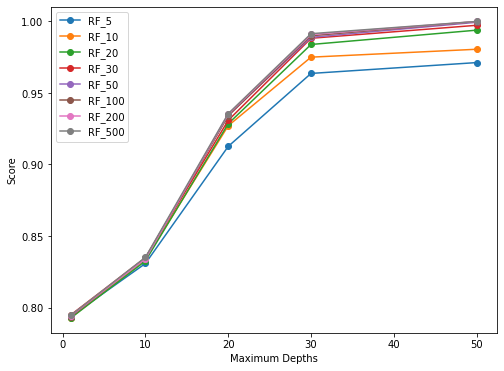

In [9]:
plt.figure(figsize=(8, 6))

for n in exploratory_estimators:
    plt.plot(exploratory_depths, [RandomForestClassifier(n_estimators=n, max_depth=i).fit(X_train, y_train).score(X_train, y_train) for i in exploratory_depths], 
             marker= 'o', label='RF_'+str(n))
    
plt.xlabel('Maximum Depths')
plt.ylabel('Score')
plt.legend()
plt.show()

According to the plot:

In [10]:
max_depth = [1, 3, 5, 7, 10, 12, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42, 45, 47, 50, 55, 60]
n_estimators = [1, 5, 10, 15, 20, 25, 30, 35, 40]

In [11]:
models_list = []
names_list = []
for n in n_estimators:
    for i in max_depth:
        models_list.append(RandomForestClassifier(n_estimators=n, max_depth=i))
        names_list.append('RF_'+str(n)+'_'+str(i))

In [12]:
metrics = classification(models_list, names_list, '../../../data/model_output/metrics/software_defect/random_forest.csv', X_train, y_train, X_validation, y_validation, metrics={})
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
RF_1_1,0.096741,0.673852,0.681044,1.067233
RF_1_3,0.118682,0.761095,0.766196,0.670318
RF_1_5,0.126662,0.776983,0.776330,-0.083941
RF_1_7,0.162566,0.778023,0.772904,-0.657875
RF_1_10,0.204452,0.790008,0.756332,-4.262780
...,...,...,...,...
RF_40_45,10.163003,0.999999,0.764560,-23.543849
RF_40_47,10.927567,0.999999,0.766542,-23.345738
RF_40_50,10.957198,0.999998,0.765210,-23.478840
RF_40_55,10.022616,0.999999,0.766559,-23.343989


In [13]:
metrics.sort_values(by='Validation_AUC', ascending=False)

,Run_Time,Train_AUC,Validation_AUC,delta%
RF_40_10,4.631957,0.821758,0.791882,-3.635720
RF_35_12,4.708903,0.848438,0.791391,-6.723746
RF_35_10,3.952673,0.821178,0.791258,-3.643532
RF_25_10,2.761127,0.821315,0.791048,-3.685203
RF_30_10,3.305808,0.821040,0.791038,-3.654153
...,...,...,...,...
RF_1_45,0.290962,0.856184,0.607931,-28.995307
RF_1_32,0.300197,0.856544,0.602409,-29.669783
RF_1_27,0.280010,0.847269,0.592630,-30.054056
RF_1_25,0.277900,0.837964,0.582963,-30.431036


The model that performs the best is **RF_40_10**, so let's retrain it and test it

In [5]:
test = pd.read_parquet('../../../data/model_input/test_sets/software_defect.parquet')

In [6]:
y_test = test.defects
X_test = test.drop(columns=['defects'])

In [7]:
retrain = pd.concat([train, validation])

In [8]:
y_retrain = retrain.defects
X_retrain = retrain.drop(columns=['defects'])

In [18]:
model = RandomForestClassifier(n_estimators=40, max_depth=10).fit(X_retrain, y_retrain)

In [19]:
test_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.7923


The model works as expected in the test.

In [20]:
dump(model, '../../../data/model_output/models/software_defect/best_random_forest.joblib')

['best_random_forest.joblib']

In [21]:
with open('../../../data/metrics/software_defect/final_AUC.txt', 'a') as f:
    f.write('\nRF, '+ str(auc))

In [9]:
from joblib import load
load_mod = load('../../../data/model_output/models/software_defect/best_random_forest.joblib')

In [10]:
train_pred = load_mod.predict_proba(X_retrain)[:, 1]
auc_train = roc_auc_score(y_retrain, train_pred)
test_pred = load_mod.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, test_pred)

In [11]:
import time 
time1 = time.time()
RandomForestClassifier(n_estimators=40, max_depth=10).fit(X_retrain, y_retrain)
time2 = time.time() - time1 

In [12]:
with open('../../../data/model_output/metrics/software_defect/final_metrics.txt', 'a') as f:
     f.write(f'\nRF; {time2}; {auc_train}; {auc_test}')